In [1]:
import numpy as np
import os
import shutil
import cv2
import mxnet as mx
ldic = {'H':0, 'N':1, 'F':2, 'T':3, 'L':4, 'M':5, 'B':6, 'GC':7,'CP':8,'C':9,'SM':10,'FT':11}
label_names = ['histiocytes','Necrosis','Fibrosis','Tumour','lymphocytes','Mucin','Blood','Germinala Centra','Capillary','Capsule','Smooth Muscle','Tumour Fibrosis']

name_list = ['H', 'N', 'F', 'T', 'L', 'M', 'B', 'D' ,'P','C','S','Y','G']

In [2]:
PATH_224 = '/mnt/DATA_CRLM/Patches/Patches_CRCLND/Patches_Level0/Patches_224/All/'
PATH_448 = '/mnt/DATA_CRLM/Patches/Patches_CRCLND/Patches_Level0/Patches_448/All/'
flist = os.listdir(PATH_224)

flist_T = [i for i in flist if i[0]=='T']
flist_F = [i for i in flist if (i[0]=='F')]
flist_N = [i for i in flist if i[0]=='N']
flist_M = [i for i in flist if i[0]=='M']
flist_B = [i for i in flist if i[0]=='B']
flist_FT = [i for i in flist if (i[0]=='Y')]


In [3]:
print len(flist_T),len(flist_F),len(flist_N),len(flist_M),len(flist_B),len(flist_FT)

28997 152 33272 3431 2459 12299


## Load Alexnet


In [6]:
import sys
import mxnet.ndarray as nd
sys.path.append('../../Coop_Work')
from Model.Gluon.AlexNet import  AlexNet,AlexNet_448
import utils
import pylab as plt

epoch=50
prefix='/mnt/DATA_CRLM/Patches/Checkpoints/Alex_224_3_24_11_8/Alex_epoch_%05d.params'%epoch
net_224=AlexNet(10,prefix='sequential0_',dropout_rate=0)
net_224.collect_params().load(prefix,utils.try_gpu())

epoch = 80
prefix='/mnt/DATA_CRLM/Patches/Checkpoints/AlexNet_448_4_2_10_8/AlexNet_epoch_%05d.params'%epoch


net_448=AlexNet_448(11,prefix='AlexNet_448_',dropout_rate=0)
net_448.collect_params().load(prefix,utils.try_gpu())

## Load VGG

In [10]:
import sys
import mxnet.ndarray as nd
sys.path.append('../../Coop_Work')
from Model.Gluon.VGG import vgg11 as VGG
import utils
import pylab as plt

epoch=50
prefix='/mnt/DATA_CRLM/Patches/Checkpoints/VGG_224_3_26_13_6/VGG_epoch_%05d.params'%epoch
net_224=VGG(10,prefix='sequential0_')
net_224.collect_params().load(prefix,utils.try_gpu())

epoch = 50
prefix='/mnt/DATA_CRLM/Patches/Checkpoints/VGG_448_4_5_11_3/VGG_epoch_%05d.params'%epoch

net_448=VGG(11,prefix='')
net_448.collect_params().load(prefix,utils.try_gpu())

## Load Resnet


In [4]:
import sys
import mxnet.ndarray as nd
sys.path.append('../../Coop_Work')
from Model.Gluon.ResNet import ResNet
import utils
import pylab as plt

# epoch=50
# prefix='/mnt/DATA_CRLM/Patches/Checkpoints/VGG_224_3_26_13_6/VGG_epoch_%05d.params'%epoch
# net_224=VGG(10,prefix='sequential0_')
# net_224.collect_params().load(prefix,utils.try_gpu())

epoch = 50
prefix='/mnt/DATA_CRLM/Patches/Checkpoints/ResNet_448_4_21_1_26/ResNet_epoch_%05d.params'%epoch

net_448=ResNet(11,prefix='')
net_448.collect_params().load(prefix,utils.try_gpu())

In [2]:

def predict_224(tpatch):
    #176, 109, 177
    ttb = (nd.array(tpatch[:,:,:3],dtype=np.float32)-nd.array([123,116,103],dtype=np.float32))/255.0
    #ttb = (nd.array(tpatch[:,:,:3],dtype=np.float32)-nd.array([176, 109, 177],dtype=np.float32))/255.0
    ttb = ttb.transpose((2,0,1))
    tbatch = nd.expand_dims(ttb,axis=0)

    #return nd.softmax(net_448.forward(tbatch.as_in_context(mx.gpu(0))))
    #return ['%.04f'%i for i in nd.softmax(net_448.forward(tbatch.as_in_context(mx.gpu(0)))).asnumpy()[0]]
    #return (net_448.forward(tbatch.as_in_context(mx.gpu(0))))
    return nd.argmax(net_224.forward(tbatch.as_in_context(mx.gpu(0))),axis=1).asnumpy()

def predict_448(tpatch):
    #176, 109, 177
    ttb = (nd.array(tpatch[:,:,:3],dtype=np.float32)-nd.array([123,116,103],dtype=np.float32))/255.0
    #ttb = (nd.array(tpatch[:,:,:3],dtype=np.float32)-nd.array([176, 109, 177],dtype=np.float32))/255.0
    ttb = ttb.transpose((2,0,1))
    tbatch = nd.expand_dims(ttb,axis=0)

    #return nd.softmax(net_448.forward(tbatch.as_in_context(mx.gpu(0))))
    #return ['%.04f'%i for i in nd.softmax(net_448.forward(tbatch.as_in_context(mx.gpu(0)))).asnumpy()[0]]
    #return (net_448.forward(tbatch.as_in_context(mx.gpu(0))))
    return nd.argmax(net_448.forward(tbatch.as_in_context(mx.gpu(0))),axis=1).asnumpy()

In [3]:
def test(flist_A,PATH,predict,tlabel):
    flist_A.sort()
    A_result = []
    for i,tf in enumerate(flist_A):
        img =  plt.imread(PATH+tf)
        r = predict(img)
        A_result.extend(list(r))
        if i%1000 ==0:
            print i,
 
    print " "
    print  np.sum(np.array(A_result)!=tlabel),len(flist_A),1-np.sum(np.array(A_result)!=tlabel)*1.0/len(flist_A)
    return A_result

In [11]:
print "TEST T*********"
result_t = test(flist_T,PATH=PATH_224,predict=predict_224,tlabel =3) #6245/28997
result_T = test(flist_T,PATH=PATH_448,predict=predict_448,tlabel =3)  2296/28997  92.08


In [10]:
PATH_out = '/mnt/DATA_CRLM/Patches/Tmp/T/'
for i,r in enumerate(result):
    if r!= 3:
        shutil.copy(PATH_448+flist_T[i],PATH_out + flist_T[i])

In [11]:
print "TEST N*********"
#result_n =test(flist_N,PATH=PATH_224,predict=predict_224,tlabel=1) #6075 33272 0.817414041837
result_N = test(flist_N,PATH=PATH_448,predict=predict_448,tlabel=1) #4975 33272 0.850474873768


TEST N*********
0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000  
4975 33272 0.850474873768


In [12]:
PATH_out = '/mnt/DATA_CRLM/Patches/Tmp/N/'
for i,r in enumerate(result_N):
    if r!= 1:
        shutil.copy(PATH_448+flist_N[i],PATH_out + flist_N[i])


In [8]:

print "TEST F*********"
#result_f = test(flist_F,PATH=PATH_224,predict=predict_224,tlabel=2) #15 152 0.901315789474
result_F = test(flist_F,PATH=PATH_448,predict=predict_448,tlabel=2) #10 152 0.934210526316


TEST F*********
0  
5 152 0.967105263158


In [18]:
print "TEST FT*********"
result_ft = test(flist_FT,PATH=PATH_224,predict=predict_224,tlabel=2)
result_FT = test(flist_FT,PATH=PATH_448,predict=predict_448,tlabel=2)

TEST FT*********
0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000  
342 12299 0.972192861208
0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000  
281 12299 0.977152614034


In [10]:
PATH_out = '/mnt/DATA_CRLM/Patches/Tmp/F/'
for i,r in enumerate(result_FT):
    if r!= 2:
        shutil.copy(PATH_448+flist_FT[i],PATH_out + flist_FT[i])


In [21]:
# print "TEST T*********"
# result_t = test(flist_T,PATH=PATH_224,predict=predict_224,tlabel=3)
# result_T = test(flist_T,PATH=PATH_448,predict=predict_448,tlabel=3)


# print "TEST N*********"
# result_n = test(flist_N,PATH=PATH_224,predict=predict_224,tlabel=1)
# result_N test(flist_N,PATH=PATH_448,predict=predict_448,tlabel=1)

# print "TEST F*********"
# result_f = test(flist_F,PATH=PATH_224,predict=predict_224,tlabel=2)
# result_F = test(flist_F,PATH=PATH_448,predict=predict_448,tlabel=2)

# print "TEST FT*********"i=0
img = plt.imread(PATH_448+flist_T[i])
a = predict_448(img)
b = predict_448_flip_left(img)
c =  predict_448_flip_up(img)
d =  predict_448_rotate_90(img)
e =  predict_448_rotate_180(img)
f =  predict_448_rotate_270(img)

print i,"-----",a,b,c,d,e,f
# result_ft = test(flist_FT,PATH=PATH_224,predict=predict_224,tlabel=2)
# result_FT = test(flist_FT,PATH=PATH_448,predict=predict_448,tlabel=2)

print "TEST M*********"
result_m =test(flist_M,PATH=PATH_224,predict=predict_224,tlabel=5) #457 3431 0.866802681434
result_M =test(flist_M,PATH=PATH_448,predict=predict_448,tlabel=5) #250 3431 0.92713494608

print "TEST B*********"
result_b = test(flist_B,PATH=PATH_224,predict=predict_224,tlabel=6) # 150 2459 0.938999593331
result_B = test(flist_B,PATH=PATH_448,predict=predict_448,tlabel=6) # 326 2459 0.867425782839

TEST M*********
0 1000 2000 3000  
457 3431 0.866802681434
0 1000 2000 3000  
250 3431 0.92713494608
TEST B*********
0 1000 2000  
150 2459 0.938999593331
0 1000 2000  
326 2459 0.867425782839


In [20]:
print "TEST T*********"
result_t = test(flist_T,PATH=PATH_224,predict=predict_224,tlabel=3)
result_T = test(flist_T,PATH=PATH_448,predict=predict_448,tlabel=3)


print "TEST N*********"
result_n = test(flist_N,PATH=PATH_224,predict=predict_224,tlabel=1)
result_N = test(flist_N,PATH=PATH_448,predict=predict_448,tlabel=1)

print "TEST F*********"
result_f = test(flist_F,PATH=PATH_224,predict=predict_224,tlabel=2)
result_F = test(flist_F,PATH=PATH_448,predict=predict_448,tlabel=2)

print "TEST FT*********"
result_ft = test(flist_FT,PATH=PATH_224,predict=predict_224,tlabel=2)
result_FT = test(flist_FT,PATH=PATH_448,predict=predict_448,tlabel=2)

print "TEST M*********"
result_m =test(flist_M,PATH=PATH_224,predict=predict_224,tlabel=5) 
result_M =test(flist_M,PATH=PATH_448,predict=predict_448,tlabel=5)

print "TEST B*********"
result_b = test(flist_B,PATH=PATH_224,predict=predict_224,tlabel=6)
result_B = test(flist_B,PATH=PATH_448,predict=predict_448,tlabel=6) 

TEST T*********
0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000  
3704 28997 0.87226264786
0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000  
6117 28997 0.789047142808
TEST N*********
0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000  
10052 33272 0.697884106756
0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000  
4576 33272 0.862466939168
TEST F*********
0  
15 152 0.901315789474
0  
10 152 0.934210526316
TEST FT*********
0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000  


## Test on Resnet

In [9]:
print "TEST T*********"
#result_t = test(flist_T,PATH=PATH_224,predict=predict_224,tlabel=3)
result_T = test(flist_T,PATH=PATH_448,predict=predict_448,tlabel=3)


print "TEST N*********"
#result_n = test(flist_N,PATH=PATH_224,predict=predict_224,tlabel=1)
result_N = test(flist_N,PATH=PATH_448,predict=predict_448,tlabel=1)

print "TEST F*********"
#result_f = test(flist_F,PATH=PATH_224,predict=predict_224,tlabel=2)
result_F = test(flist_F,PATH=PATH_448,predict=predict_448,tlabel=2)

print "TEST FT*********"
#result_ft = test(flist_FT,PATH=PATH_224,predict=predict_224,tlabel=2)
result_FT = test(flist_FT,PATH=PATH_448,predict=predict_448,tlabel=2)

print "TEST M*********"
#result_m =test(flist_M,PATH=PATH_224,predict=predict_224,tlabel=5) 
result_M =test(flist_M,PATH=PATH_448,predict=predict_448,tlabel=5)

print "TEST B*********"
#result_b = test(flist_B,PATH=PATH_224,predict=predict_224,tlabel=6)
result_B = test(flist_B,PATH=PATH_448,predict=predict_448,tlabel=6) 

TEST T*********
0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000  
2701 28997 0.90685243301
TEST N*********
0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000  
3817 33272 0.8852789132
TEST F*********
0  
5 152 0.967105263158
TEST FT*********
0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000  
166 12299 0.986502967721
TEST M*********
0 1000 2000 3000  
188 3431 0.945205479452
TEST B*********
0 1000 2000  
279 2459 0.886539243595


# Test Rotate Accuraccy

In [56]:
from skimage.transform import rotate


def predict_448(tpatch):
    #176, 109, 177
    ttb = (nd.array(tpatch[:,:,:3],dtype=np.float32)-nd.array([123,116,103],dtype=np.float32))/255.0
    #ttb = (nd.array(tpatch[:,:,:3],dtype=np.float32)-nd.array([176, 109, 177],dtype=np.float32))/255.0
    ttb = ttb.transpose((2,0,1))
    tbatch = nd.expand_dims(ttb,axis=0)

    #return nd.softmax(net_448.forward(tbatch.as_in_context(mx.gpu(0))))
    #return ['%.04f'%i for i in nd.softmax(net_448.forward(tbatch.as_in_context(mx.gpu(0)))).asnumpy()[0]]
    #return (net_448.forward(tbatch.as_in_context(mx.gpu(0))))
    return nd.argmax(net_448.forward(tbatch.as_in_context(mx.gpu(0))),axis=1).asnumpy()

def predict_448_flip_left(tpatch):
    
    ttb1 = (nd.image.flip_left_right(nd.array(tpatch[:,:,:3],dtype=np.float32))-nd.array([123,116,103],dtype=np.float32))/255.0
    ttb1 = ttb1.transpose((2,0,1))
    tbatch1 = nd.expand_dims(ttb1,axis=0)
    return nd.argmax(net_448.forward(tbatch1.as_in_context(mx.gpu(0))),axis=1).asnumpy()

def predict_448_flip_up(tpatch):
    
    ttb1 = (nd.image.flip_top_bottom(nd.array(tpatch[:,:,:3],dtype=np.float32))-nd.array([123,116,103],dtype=np.float32))/255.0
    ttb1 = ttb1.transpose((2,0,1))
    tbatch1 = nd.expand_dims(ttb1,axis=0)
    return nd.argmax(net_448.forward(tbatch1.as_in_context(mx.gpu(0))),axis=1).asnumpy()


def predict_448_rotate_90(tpatch):
    ttb3 = (nd.array(rotate(tpatch[:,:,:3],90),dtype=np.float32)*255.0-nd.array([123,116,103],dtype=np.float32))/255.0
    ttb3 = i=0
    
img = plt.imread(PATH_448+flist_T[i])
a = predict_448(img)
b = predict_448_flip_left(img)
c =  predict_448_flip_up(img)
d =  predict_448_rotate_90(img)
e =  predict_448_rotate_180(img)
f =  predict_448_rotate_270(img)

print i,"-----",a,b,c,d,e,fttb3.transpose((2,0,1))
    tbatch3 = nd.expand_dims(ttb3,axis=0)
    return nd.argmax(net_448.forward(tbatch3.as_in_context(mx.gpu(0))),axis=1).asnumpy()
    


def predict_448_rotate_180(tpatch):
    ttb3 = (nd.array(rotate(tpatch[:,:,:3],180),dtype=np.float32)*255.0-nd.array([123,116,103],dtype=np.float32))/255.0
    ttb3 = ttb3.transpose((2,0,1))
    tbatch3 = nd.expand_dims(ttb3,axis=0)
    return nd.argmax(net_448.forward(tbatch3.as_in_context(mx.gpu(0))),axis=1).asnumpy()
    
def predict_448_rotate_270(tpatch):
    ttb3 = (nd.array(rotate(tpatch[:,:,:3],270),dtype=np.float32)*255.0-nd.array([123,116,103],dtype=np.float32))/255.0
    ttb3 = ttb3.transpose((2,0,1))
    tbatch3 = nd.expand_dims(ttb3,axis=0)
    return nd.argmax(net_448.forward(tbatch3.as_in_context(mx.gpu(0))),axis=1).asnumpy()
  
    

def predict_448_multiview(tpatch):
    pass



In [57]:
#for i in range(100):
i=0
img = plt.imread(PATH_448+flist_T[i])
a = predict_448(img)
b = predict_448_flip_left(img)
c =  predict_448_flip_up(img)
d =  predict_448_rotate_90(img)
e =  predict_448_rotate_180(img)
f =  predict_448_rotate_270(img)

print i,"-----",a,b,c,d,e,f

0 ----- [ 3.] [ 3.] [ 3.] [ 3.] [ 3.] [ 3.]


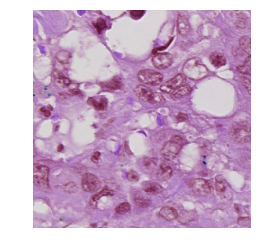

In [39]:
img = plt.imread(PATH_448+flist_T[25])
plt.imshow(img)
plt.axis('off')
plt.show()